<a href="https://colab.research.google.com/github/Prathika-123/EcoAssistantAgent/blob/main/new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import re
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:

# ============================
# 1️⃣ Load Dataset
# ============================
df = pd.read_csv("flipkart_products_with_fixed_labels.csv")

label_map = {
    "not eco-friendly": 0,
    "moderate": 1,
    "eco-friendly": 2
}

df["label"] = df["Eco_Label_Fixed"].str.strip().str.lower().map(label_map)
df = df.dropna(subset=["label"])

In [ ]:
# ============================
# 2️⃣ Text Cleaning Function
# ============================
def clean_text(text):
    if pd.isna(text): return ""
    text = str(text).lower()
    text = re.sub(r"[^a-z0-9\s]", " ", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()

df["text_clean"] = (
    df["product_name"].fillna("") + " " +
    df["brand"].fillna("") + " " +
    df["spec_readable"].fillna("")
).apply(clean_text)

X = df["text_clean"]
y = df["label"]


In [ ]:
# ============================
# 3️⃣ Train/Test Split
# ============================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)


In [ ]:
# ============================
# 4️⃣ Word TF-IDF + Char TF-IDF
# ============================
tfidf_word = TfidfVectorizer(
    max_features=8000,
    ngram_range=(1,2),
    min_df=2,
    max_df=0.8
)

tfidf_char = TfidfVectorizer(
    analyzer="char",
    ngram_range=(3,5),
    min_df=2
)

# Combined features
combined_features = FeatureUnion([
    ("word", tfidf_word),
    ("char", tfidf_char)
])

In [ ]:

# ============================
# 5️⃣ Build Combined Pipeline
# ============================
pipeline = Pipeline([
    ("features", combined_features),
    ("clf", LinearSVC(class_weight="balanced"))
])

In [ ]:
# ============================
# 6️⃣ Hyperparameter Optimization
# ============================
param_grid = {
    "clf__C": [0.5, 1, 2],
}

grid = GridSearchCV(
    pipeline,
    param_grid,
    scoring="f1_macro",
    cv=5,
    n_jobs=-1,
    verbose=2
)

print("\nTraining model... please wait...\n")
grid.fit(X_train, y_train)

print(f"\nBest Model Parameters: {grid.best_params_}")

best_model = grid.best_estimator_


Training model... please wait...

Fitting 5 folds for each of 3 candidates, totalling 15 fits

Best Model Parameters: {'clf__C': 2}


In [ ]:
# ============================
# 7️⃣ Evaluation
# ============================
y_pred = best_model.predict(X_test)

print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n")
print(classification_report(
    y_test, y_pred,
    target_names=["Not Eco-Friendly", "Moderate", "Eco-Friendly"]
))


Accuracy: 0.98105927744651

Classification Report:

                  precision    recall  f1-score   support

Not Eco-Friendly       0.97      0.98      0.98      1618
        Moderate       0.97      0.97      0.97      1326
    Eco-Friendly       0.99      0.98      0.99      2758

        accuracy                           0.98      5702
       macro avg       0.98      0.98      0.98      5702
    weighted avg       0.98      0.98      0.98      5702



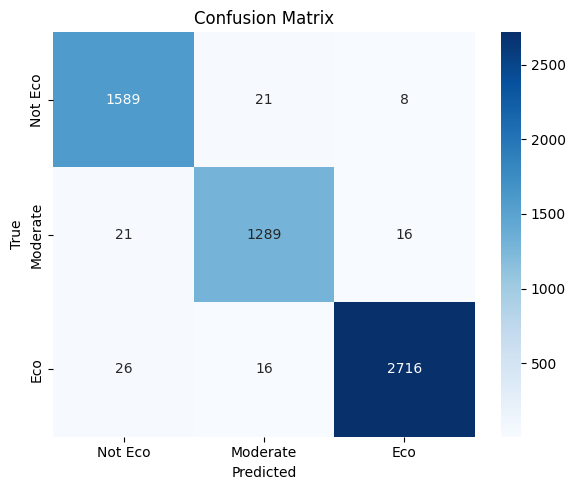

In [ ]:
# ============================
# 8️⃣ Confusion Matrix
# ============================
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues",
    xticklabels=["Not Eco", "Moderate", "Eco"],
    yticklabels=["Not Eco", "Moderate", "Eco"]
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


In [ ]:
# ============================
# 9️⃣ Save Best Model
# ============================
joblib.dump(best_model, "eco_friendly_model_optimized.joblib")
print("\nModel saved as eco_friendly_model_optimized.joblib")


Model saved as eco_friendly_model_optimized.joblib


In [ ]:
# =============================
# 🔟 Prediction Function
# =============================
def predict_product(text):
    cleaned = clean_text(text)
    pred = best_model.predict([cleaned])[0]
    mapping = {0: "Not Eco-Friendly", 1: "Moderate", 2: "Eco-Friendly"}
    return mapping[pred]

# Test
tests = [
    "Bamboo toothbrush biodegradable eco",
    "Plastic bucket heavy duty",
    "Organic cotton bedsheet natural fabric",
    "Disposable plastic plates",
]

print("\nSample Predictions:\n")
for t in tests:
    print(f"{t} → {predict_product(t)}")


Sample Predictions:

Bamboo toothbrush biodegradable eco → Eco-Friendly
Plastic bucket heavy duty → Not Eco-Friendly
Organic cotton bedsheet natural fabric → Eco-Friendly
Disposable plastic plates → Not Eco-Friendly
